In [32]:
import numpy as np
import keras
import cv2
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

In [2]:
file_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\img"
labels_path = "D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\cartoon_set\labels.csv"

In [3]:
df = pd.read_csv(labels_path)
sample_size = 1000
df = df.drop(columns="Unnamed: 0")

temp = df["file_name"]
df.insert(loc=0, column="file_names", value=temp)
df = df.drop(columns="file_name")

df["eye_color"] = df["eye_color"].replace(to_replace=[0], value=["Brown"])
df["eye_color"] = df["eye_color"].replace(to_replace=[1], value=["Blue"])
df["eye_color"] = df["eye_color"].replace(to_replace=[2], value=["Green"])
df["eye_color"] = df["eye_color"].replace(to_replace=[3], value=["Hazel"])
df["eye_color"] = df["eye_color"].replace(to_replace=[4], value=["Black"])

one_hot = pd.get_dummies(df["eye_color"])
df = df.join(one_hot)

df = df.drop(df.index[sample_size:])

In [4]:
train, validation, test = \
              np.split(df.sample(frac=1), 
                       [int(.6*len(df)), int(.8*len(df))])

In [5]:
train

,file_names,eye_color,face_shape,Black,Blue,Brown,Green,Hazel
506,506.png,Black,3,1,0,0,0,0
694,694.png,Hazel,3,0,0,0,0,1
698,698.png,Brown,1,0,0,1,0,0
24,24.png,Hazel,2,0,0,0,0,1
606,606.png,Black,4,1,0,0,0,0
...,...,...,...,...,...,...,...,...
3,3.png,Green,0,0,0,0,1,0
685,685.png,Blue,1,0,1,0,0,0
788,788.png,Green,0,0,0,0,1,0
79,79.png,Blue,1,0,1,0,0,0


In [6]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [7]:
img_path = os.path.join(file_path, df["file_names"].iloc[3])
img = cv2.imread(img_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        roi_color_eye = roi_color[ey:ey+eh, ex:ex+ew]
        rx, ry, rw, rh = ex, ey, ew, eh
        print("y=", y, "x=", x, "w=", w, "h=", h, "ry=", ry, "rx=", rx, "rw=", rw, "rh=", rh)
        break
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        roi = roi_color[ey:ey+eh, ex: ex+ew]

y= 149 x= 128 w= 248 h= 248 ry= 83 rx= 48 rw= 56 rh= 56


In [8]:
starty = y + ry
endy = starty + rh
startx = x + rx
endx = startx + rw

In [9]:
def create_hsi_matrix(file_path, df, face, eye, starty, endy, startx, endx):
    eyes = []
    labels = []
    for file_name in df["file_names"]:
        img_path = os.path.join(file_path, file_name)
        img = cv2.imread(img_path)
        crop = img[starty:endy, startx:endx]
        hsi_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
        avg_hue = hsi_crop[:,:,0].mean()
        avg_sat = hsi_crop[:,:,1].mean()
        avg_val = hsi_crop[:,:,2].mean()
        eyes.append([avg_hue, avg_sat, avg_val])
        temp = file_name.split(".")[0]
        labels.append(df["eye_color"].loc[int(temp)])
    eyes = np.array(eyes).astype(int)
    return eyes, labels

In [10]:
def create_rgb_matrix(file_path, df, face, eye, starty, endy, startx, endx):
    eyes = []
    labels = []
    for file_name in df["file_names"]:
        img_path = os.path.join(file_path, file_name)
        img = cv2.imread(img_path)
        crop = img[starty:endy, startx:endx]
        avg_red = crop[:,:,0].mean()
        avg_green = crop[:,:,1].mean()
        avg_blue = crop[:,:,2].mean()
        eyes.append([avg_red, avg_green, avg_blue])
        temp = file_name.split(".")[0]
        labels.append(df["eye_color"].loc[int(temp)])
    eyes = np.array(eyes).astype(int)
    return eyes, labels

In [11]:
def create_eye_matrix(file_path, df, face, eye, starty, endy, startx, endx):
    eyes = []
    labels = []
    for file_name in df["file_names"]:
        img_path = os.path.join(file_path, file_name)
        img = cv2.imread(img_path)
        crop = img[starty:endy, startx:endx]
        eyes.append(crop)
        temp = file_name.split(".")[0]
        labels.append([df["Black"].loc[int(temp)], 
                       df["Blue"].loc[int(temp)], 
                       df["Brown"].loc[int(temp)], 
                       df["Green"].loc[int(temp)], 
                       df["Hazel"].loc[int(temp)]])
    eyes = np.array(eyes).astype(int)
    return eyes, labels

In [12]:
img_path = os.path.join(file_path, "444.png")
img = cv2.imread(img_path)
crop = img[starty:endy, startx:endx]
hsi_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
out = []
for block in hsi_crop:
    for pixel in block:
        out.append(pixel[0])
print(np.mean(out))
print(hsi_crop[:,:,0].mean())

9.982142857142858
9.982142857142858


In [13]:
cv2.imshow("bruh",crop)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
train_hsi, train_labelshsi = create_hsi_matrix(file_path, train, face_cascade, eye_cascade, starty, endy, startx, endx)

In [15]:
valid_hsi, valid_labelshsi = create_hsi_matrix(file_path, validation, face_cascade, eye_cascade, starty, endy, startx, endx)

In [37]:
test_hsi, test_labelshsi = create_hsi_matrix(file_path, test, face_cascade, eye_cascade, starty, endy, startx, endx)

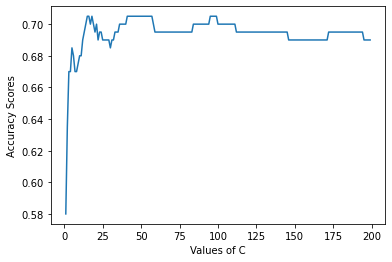

In [17]:
C = np.arange(1, 200)
scores1 = []
for i in C:
    classifier = svm.SVC(kernel="rbf", C=i)
    classifier.fit(train_hsi, train_labelshsi)
    Y_pred = classifier.predict(valid_hsi)
    accuracy = metrics.accuracy_score(valid_labelshsi, y_pred=Y_pred)
    scores1.append(accuracy)
plt.plot(C, scores1)
plt.xlabel('Values of C')
plt.ylabel('Accuracy Scores')
plt.show()

In [18]:
print(np.max(scores1))

0.705


In [19]:
train_rgb, train_labelsrgb = create_rgb_matrix(file_path, train, face_cascade, eye_cascade, starty, endy, startx, endx)

In [20]:
valid_rgb, valid_labelsrgb = create_rgb_matrix(file_path, validation, face_cascade, eye_cascade, starty, endy, startx, endx)

In [21]:
test_rgb, test_labelsrgb = create_rgb_matrix(file_path, test, face_cascade, eye_cascade, starty, endy, startx, endx)

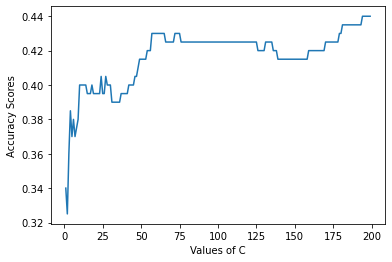

In [22]:
scores2 = []
for i in C:
    classifier = svm.SVC(kernel="rbf", C=i)
    classifier.fit(train_rgb, train_labelsrgb)
    Y_pred = classifier.predict(valid_rgb)
    accuracy = metrics.accuracy_score(valid_labelsrgb, y_pred=Y_pred)
    scores2.append(accuracy)
plt.plot(C, scores2)
plt.xlabel('Values of C')
plt.ylabel('Accuracy Scores')
plt.show()

In [23]:
print(np.max(scores2))

0.44


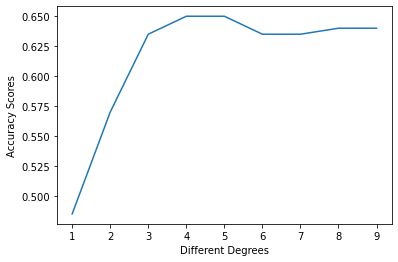

In [24]:
deg = range(1,10)
scores3= []
for i in deg:
    classifier = svm.SVC(kernel="poly", degree=i)
    classifier.fit(train_hsi, train_labelshsi)
    Y_pred = classifier.predict(valid_hsi)
    accuracy = metrics.accuracy_score(valid_labelshsi, y_pred=Y_pred)
    scores3.append(accuracy)
plt.plot(deg, scores3)
plt.xlabel("Different Degrees")
plt.ylabel("Accuracy Scores")
plt.show()

In [25]:
print(np.max(scores3))

0.65


In [26]:
train_eyes, train_labels = create_eye_matrix(file_path, train, face_cascade, eye_cascade, starty, endy, startx, endx)

In [27]:
val_eyes, val_labels = create_eye_matrix(file_path, validation, face_cascade, eye_cascade, starty, endy, startx, endx)

In [28]:
test_eyes, test_labels = create_eye_matrix(file_path, test, face_cascade, eye_cascade, starty, endy, startx, endx)

In [30]:
classifier = svm.SVC(kernel="rbf", C=50)
classifier.fit(train_hsi, train_labelshsi)
Y_pred = classifier.predict(valid_hsi)
accuracy = metrics.accuracy_score(valid_labelshsi, y_pred=Y_pred) 

In [34]:
model_name = "HSI_SVM.sav"

In [35]:
pickle.dump(classifier, open(model_name, "wb"))

In [39]:
print(metrics.accuracy_score(test_labelshsi, y_pred=classifier.predict(test_hsi)))

0.74
